### Loading G-Drive

In [1]:
from google.colab import drive  
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Importing the Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [3]:
%cd /content/gdrive/MyDrive/images/dida_task

/content/gdrive/MyDrive/images/dida_task


## Approach 1

### Utility Functions

In [4]:
#### Seeing the renamed files
train_image_path = './train/images'
train_label_path = './train/labels'

tr = sorted(os.listdir(train_image_path))
lb = sorted(os.listdir(train_label_path))
len(tr),len(lb),lb[:5],tr[:5]

(25,
 25,
 ['1.png', '10.png', '11.png', '12.png', '13.png'],
 ['1.png', '10.png', '11.png', '12.png', '13.png'])

#### Renaming the images for simplicity

In [ ]:
# # Set the path to your train directories
# train_image_path = '/content/gdrive/MyDrive/images/dida_task/train/images'
# train_label_path = '/content/gdrive/MyDrive/images/dida_task/train/labels'

# # Rename the image files
# image_files = sorted(os.listdir(train_image_path))
# for i, file in enumerate(image_files):
#     src = os.path.join(train_image_path, file)
#     dst = os.path.join(train_image_path, f"{i+1}.png")
#     os.rename(src, dst)

# # Rename the label files
# label_files = sorted(os.listdir(train_label_path))
# for i, file in enumerate(label_files):
#     src = os.path.join(train_label_path, file)
#     dst = os.path.join(train_label_path, f"{i+1}.png")
#     os.rename(src, dst)


#### Image Processing without Augmentation

In [5]:
def train_test_img_loader(path: list[str], size:int)-> np.array:
  image_files = os.listdir(path)
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = resize(image, (size,size))
    images.append(resized_image)
  return np.array(images)

def label_img_loader(path:list[str],size:int)-> np.array:
  image_files = os.listdir(path)
  images = []
  for file in image_files:
    image_path = os.path.join(path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_label = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized_label = resize(gray_label, (size,size))
    #binary_image = np.where(image>0.5,1,0)
    thr_label = (resized_label > 0.5).astype('float32') # Binary Masking for the pixels, any pixel value greater than 0.5 is considered as part of roof else not roof.
    #proportion = np.sum(binary_image)/(image.shape[0] * image.shape[1])
    images.append(thr_label)
  return np.array(images)

### Load Images and preprocess them

In [6]:
train_image_path = './train/images'
train_label_path = './train/labels'
test_image_path = './test/images'

train_images = train_test_img_loader(train_image_path,255)
train_labels = label_img_loader(train_label_path,255)
test_images = train_test_img_loader(test_image_path,255)

# Normalizing the images and making label images having enough channels for NN.
processed_train_images = train_images.astype('float32')
processed_test_images = test_images.astype('float32')
processed_train_labels = train_labels.reshape(*train_labels.shape, 1)

In [7]:
train_labels.shape

(25, 255, 255)

In [8]:
processed_train_images.shape

(25, 255, 255, 3)

In [9]:
processed_train_labels.shape

(25, 255, 255, 1)

#### Viewing the images

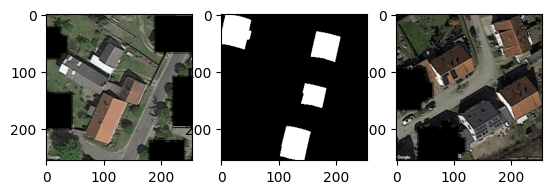

In [12]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(processed_train_images[1])
axs[1].imshow(processed_train_labels[1].squeeze(), cmap='gray')
axs[2].imshow(processed_test_images[1])
plt.show()

### Modelling


#### Base CNN Model

In [46]:
# Define the CNN model
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(255 * 255, activation='sigmoid')) # Output layer with 255*255 units

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn.fit(processed_train_images, processed_train_labels.reshape(-1, 255 * 255), epochs=10, batch_size=5)

Epoch 1/10
5/5 [==============================] - 11s 29ms/step - loss: 0.6715 - accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 28ms/step - loss: 0.4615 - accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3954 - accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3766 - accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 25ms/step - loss: 0.3711 - accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3668 - accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3646 - accuracy: 0.0000e+00
Epoch 8/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3641 - accuracy: 0.0000e+00
Epoch 9/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3597 - accuracy: 0.0000e+00
Epoch 10/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3617 - accuracy:

1/1 [==============================] - 0s 24ms/step


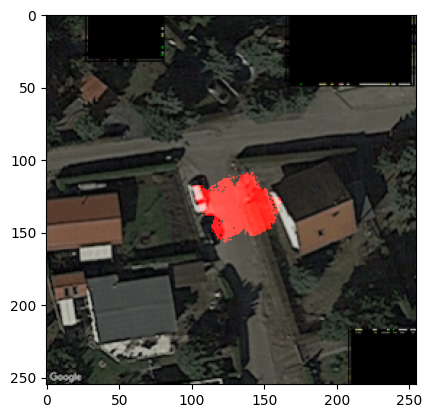

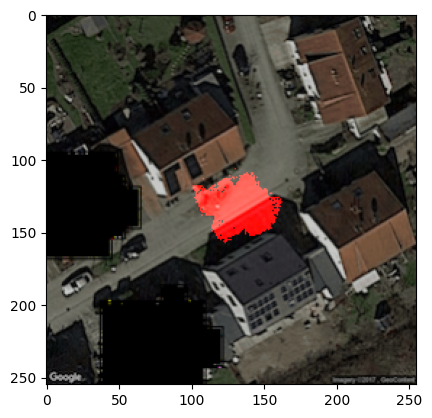

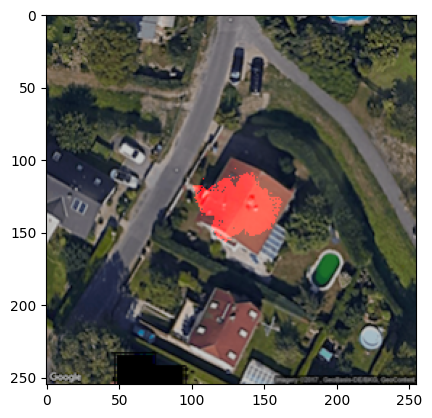

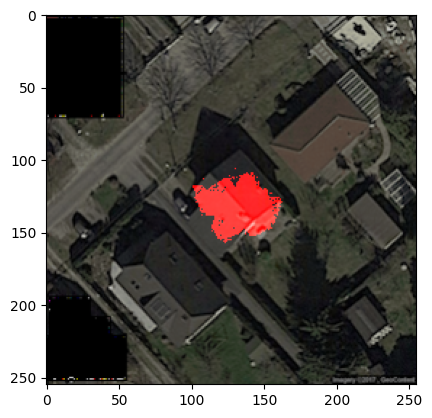

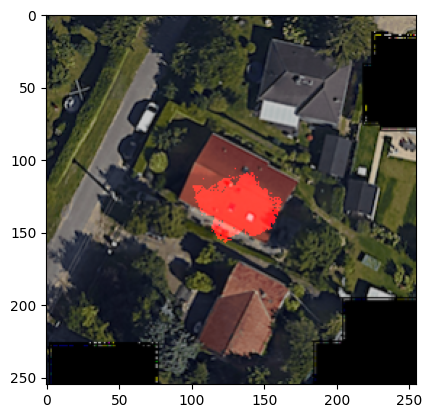

In [48]:
threshold = 0.5 # set threshold value
predicted_images = cnn.predict(test_images) # predict on test images

# apply threshold and convert to binary images
binary_images = (predicted_images > threshold).astype('uint8')
binary_images = np.reshape(binary_images, (-1, 255, 255, 1))
# highlight rooftops in binary images
for i in range(binary_images.shape[0]):
    test_image = test_images[i]
    binary_image = binary_images[i].squeeze()
    rooftop_image = np.zeros_like(test_image)
    rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
    final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0) # blend images
    plt.imshow(final_image)
    plt.show()

### Resnet 50 

In [49]:
# Define input shape
input_shape = (255, 255, 3)

# Define base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(255*255, activation='sigmoid')(x)

# Freeze all base layers in the model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet = Model(inputs=base_model.input, outputs=predictions)
resnet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
resnet.fit(processed_train_images, processed_train_labels.reshape(-1, 255 * 255), epochs=10, batch_size=5)

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
5/5 [==============================] - 5s 47ms/step - loss: 0.5520 - accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3994 - accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 45ms/step - loss: 0.3770 - accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 45ms/step - loss: 0.3773 - accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3643 - accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3650 - accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3587 - accuracy: 0.0000e+00
Epoch 8/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3595 - accuracy: 0.0000e+00
Epoch 9/10
5/5 [==============================] - 0s 46ms/step - loss: 0.3594 - accuracy: 0.0000e+00
Epoch 10/10
5/5 [=========

1/1 [==============================] - 2s 2s/step


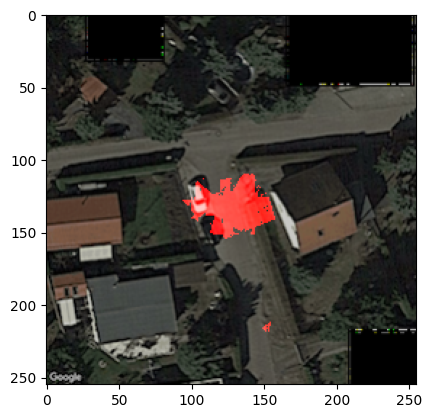

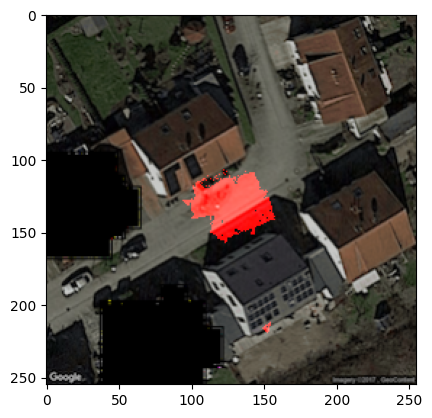

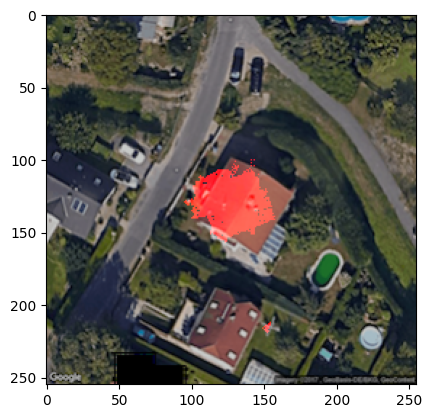

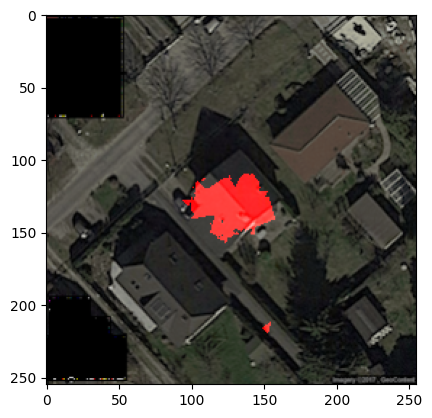

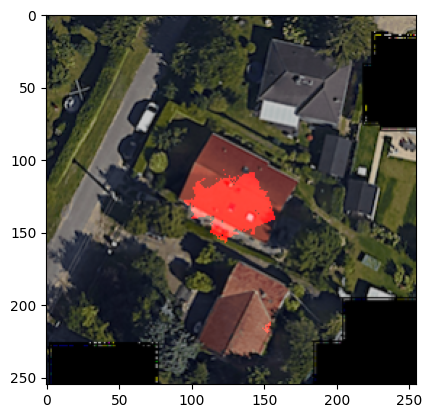

In [50]:
threshold = 0.5 # set threshold value
predicted_images = resnet.predict(test_images) # predict on test images

# apply threshold and convert to binary images
binary_images = (predicted_images > threshold).astype('uint8')
binary_images = np.reshape(binary_images, (-1, 255, 255, 1))
# highlight rooftops in binary images
for i in range(binary_images.shape[0]):
    test_image = test_images[i]
    binary_image = binary_images[i].squeeze()
    rooftop_image = np.zeros_like(test_image)
    rooftop_image[:,:,0] = binary_image*255 # set red channel to binary image
    final_image = cv2.addWeighted(test_image, 0.8, rooftop_image, 0.2, 0) # blend images
    plt.imshow(final_image)
    plt.show()

In [ ]:
# # Define the model architecture
# def create_model(num_filters=32, kernel_size=(3, 3), activation='relu', optimizer='adam'):
#     model = Sequential()
#     model.add(Conv2D(num_filters, kernel_size=kernel_size, activation=activation, input_shape=(255, 255, 3)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(num_filters*2, kernel_size=kernel_size, activation=activation))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128, activation=activation))
#     model.add(Dense(255*255, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     return model

# # Load the data
# train_images = processed_train_images
# train_labels = processed_train_labels.reshape(-1, 255 * 255)

# # Create a KerasClassifier with the create_model function and set up the parameter grid
# param_grid = {'num_filters': [16, 32, 64],
#               'kernel_size': [(3,3), (5,5)],
#               'activation': ['relu', 'sigmoid'],
#               'optimizer': ['adam', 'sgd']}
# model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

# # Use RandomizedSearchCV to find the best model hyperparameters
# search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3)
# search.fit(train_images, train_labels)

# # Print the best hyperparameters and the best accuracy
# print("Best hyperparameters: ", search.best_params_)
# print("Best accuracy: ", search.best_score_)

# # Make predictions on the test set
# predicted_labels = search.predict(processed_test_images)

# # Compute the test set accuracy
# # accuracy = accuracy_score(test_labels, predicted_labels)
# # print("Test set accuracy: ", accuracy)
# # Best hyperparameters:  {'optimizer': 'adam', 'num_filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'}

## Image Augmentation

In [55]:
def img_aug(train_path: str, test_path: str, batch_size: int, size: int):
  train_datagen = ImageDataGenerator(
      #rescale = 1./255
      rotation_range = 20,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.2,
      horizontal_flip = True,
      vertical_flip = True,
      fill_mode = 'nearest'
  )

  test_datagen = ImageDataGenerator()

  train_generator = train_datagen.flow_from_directory(
      train_path,
      target_size = (size,size),
      batch_size = batch_size,
      class_mode = 'input' # to load both the image and label data from the same directory
      )
  
  test_generator = test_datagen.flow_from_directory(
      test_path,
      target_size = (size,size),
      batch_size = batch_size,
      class_mode = None
      )
  return train_generator, test_generator

In [63]:
train_path = './train/'
test_path = './test/'
train_generator, test_generator = img_aug(train_path,test_path,batch_size = 5,size = 255)

Found 50 images belonging to 2 classes.
Found 5 images belonging to 1 classes.


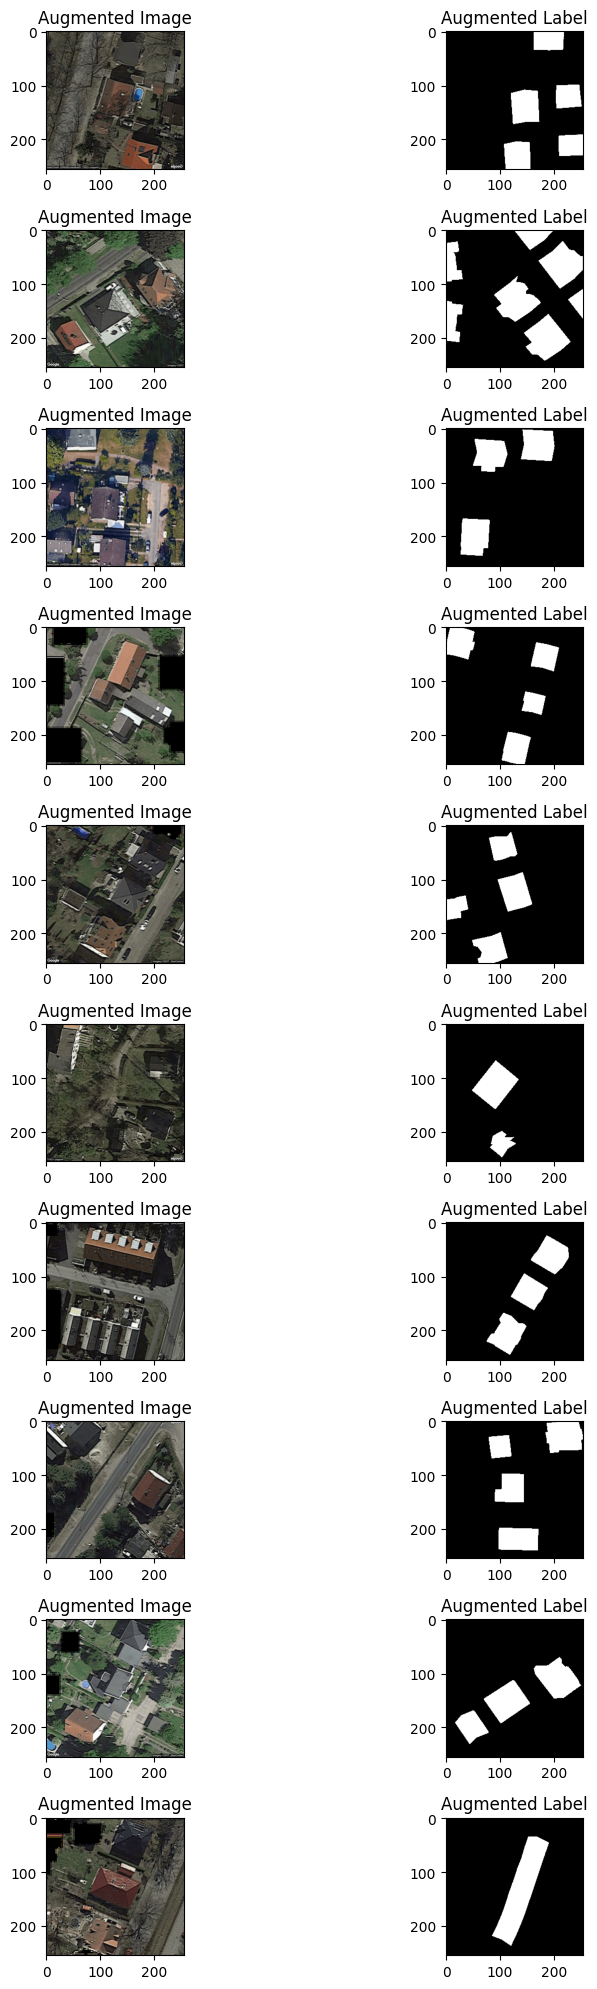

In [13]:
import matplotlib.pyplot as plt

# create generator for training data with data augmentation
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest')

# create generator for training data
train_generator = train_datagen.flow(
        processed_train_images, 
        processed_train_labels, 
        batch_size=10)

# get one batch of augmented images and labels
aug_images, aug_labels = train_generator.next()

# plot the augmented images and labels
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    axs[i, 0].imshow(aug_images[i])
    axs[i, 0].set_title('Augmented Image')
    axs[i, 1].imshow(aug_labels[i,:,:,0], cmap='gray')
    axs[i, 1].set_title('Augmented Label')
fig.tight_layout()
plt.show()


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# Define the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from convolutional layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(225*225, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss=binary_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model using the train_datagen generator for data augmentation
model.fit(train_generator,epochs=10)

Epoch 1/10


ValueError: ignored

In [ ]:
import numpy as np
from PIL import Image

# Load the original images and their labels
images = np.zeros((25, 255, 255, 3), dtype=np.uint8)
labels = np.zeros((25, 255, 255), dtype=np.uint8)

for i in range(25):
    images[i] = np.array(Image.open(f'image_{i}.jpg'))
    labels[i] = np.array(Image.open(f'label_{i}.jpg').convert('L'))

# Perform vertical and horizontal flips
augmented_images = np.concatenate((images, np.flip(images, axis=1), np.flip(images, axis=2)))
augmented_labels = np.concatenate((labels, np.flip(labels, axis=1), np.flip(labels, axis=2)))

# Save the augmented images and labels
for i in range(75):
    Image.fromarray(augmented_images[i]).save(f'augmented_image_{i}.jpg')
    Image.fromarray(augmented_labels[i]).save(f'augmented_label_{i}.jpg')
